### <b>一. 稳健性检验的意义</b>

##### 在量化研究中，我们追求的不仅仅是一个在历史回测中表现优异的Alpha策略，更重要的是：它是否能在未来、在不同市场条件下，依然保持类似的效果。这就是“稳健性”（robustness）的核心含义。

##### 因子稳健性检验，指的是通过一系列系统性的测试手段，验证一个因子是否具有下列特征：

##### 1. 一致性：是否在不同的时间段、市场、股票池或中性化条件下都能稳定地产生超额收益；

##### 2. 抗噪性：是否对个别极端数据点不敏感；

##### 3. 抗过拟合能力：是否不依赖于特定的历史数据结构；

##### 4. 泛化能力：是否能够在样本外数据（如未来数据或不同子市场）中维持有效性。

### <b>二. 工具简介</b>
##### 将因子表达式放在不同的Neutralization以及不同的Decay设置下生成对照组Alpha进行回测，从而确定信号是否稳健是否存在过拟合现象，如果信号文件则可以选出综合表现最优的设置，避免因子欠拟合。
##### <b>源代码来自 JL71699

### <b>三. 工作流程</b>
##### 1. 获取目标alpha的expr和settings信息
##### 2. 遍历neutralization和decay生成alpha_json
##### 3. 回测对照组alphas
##### 4. 将结果可视化
##### 5. 判断因子是否稳健/提交哪个
###### *注：请预先留出一个卡槽为后续对照组回测准备*

### <b>四. 环境准备</b>
#####  python_version >= 3.13.2
#####  matplotlib >= 3.10.1
#####  pandas >= 2.2.3

In [ ]:
# 导入官方库
import json
import os
import requests
from requests.auth import HTTPBasicAuth
import time

# 导入第三方库
from dotenv import load_dotenv  # 导入环境变量，非必需 pip install python-dotenv
import matplotlib.pyplot as plt
import pandas as pd

# 读取环境变量文件
load_dotenv()

### <b>五. 定义函数</b>

In [ ]:
def login():
    """
    Log in to the WorldQuant API using credentials stored in environment variables.

    This function creates a session that includes authentication credentials from environment
    variables and sends a POST request to the WorldQuant API's authentication endpoint. The
    response content is printed, and the session is returned for further interaction with the
    API.

    Returns:
        requests.Session: A session object with authentication credentials and headers.

    Raises:
        Any exceptions raised by the `requests` library during the network operations are
        propagated to the caller.
    """
    username = os.getenv("WQ_EMAIL")
    password = os.getenv("WQ_PASSWORD")

    # Create a session to persistently store the headers
    s = requests.Session()

    # Save credentials into session
    s.auth = (username, password)

    # Send a POST request to the /authentication API
    response = s.post('https://api.worldquantbrain.com/authentication')
    print(response.content)
    return s


def locate_alpha(s, alpha_id):
    """
    Retrieve and parse alpha data from an API.

    This function sends an HTTP GET request to retrieve alpha data from a specified
    API using the given alpha identifier. Upon receiving a response, it checks for
    rate-limiting headers and waits if necessary. The function then decodes the
    response content, extracts relevant performance metrics and alpha settings,
    and returns them in a list.

    Parameters:
        s (Session): A requests.Session object used for making the HTTP GET request.
        alpha_id (str): The unique identifier for the alpha to be retrieved.

    Returns:
        list: A list containing extracted alpha data, including
            - alpha_id (str)
            - sharpe (float)
            - turnover (float)
            - fitness (float)
            - margin (float)
            - expr (str): Alpha's code expression.
            - region (str): Associated region of the alpha.
            - universe (str): Universe setting for the alpha.
            - neutralization (str): Neutralization setting.
            - decay (float)
            - truncation (float)
    """
    while True:
        alpha = s.get("https://api.worldquantbrain.com/alphas/" + alpha_id)
        if "retry-after" in alpha.headers:
            time.sleep(float(alpha.headers["Retry-After"]))
        else:
            break
    string = alpha.content.decode('utf-8')
    metrics = json.loads(string)

    sharpe = metrics["is"]["sharpe"]
    fitness = metrics["is"]["fitness"]
    turnover = metrics["is"]["turnover"]
    margin = metrics["is"]["margin"]
    decay = metrics["settings"]["decay"]
    delay = metrics["settings"]["delay"]
    exp = metrics['regular']['code']
    universe=metrics["settings"]["universe"]
    truncation=metrics["settings"]["truncation"]
    neutralization=metrics["settings"]["neutralization"]
    region=metrics["settings"]["region"]

    triple = [alpha_id, sharpe, turnover, fitness, margin, exp, region, universe, neutralization, decay, delay, truncation]
    return triple


def get_pnl(s, alpha_id):
    """
    Fetches the profit and loss (PnL) data for a given alpha ID by making requests to an API endpoint.
    The function handles retry logic for requests when a 'Retry-After' header
    is present in the response from the server.

    Parameters:
        s: requests.Session
            The session object used to make requests to the API.
        alpha_id: str
            The unique identifier of the alpha whose PnL data is to be fetched.

    Returns:
        requests.Response
            The API response containing PnL data.

    Raises:
        No explicit exceptions are raised within the function, but exceptions
        related to HTTP requests (such as connection errors) may occur.

    """
    while True:
        pnl = s.get('https://api.worldquantbrain.com/alphas/' + alpha_id + '/recordsets/pnl')
        if pnl.headers.get('Retry-After', 0) == 0:
             break
        time.sleep(float(pnl.headers['Retry-After']))
    return pnl

### <b>六. 获取目标alpha信息并生成对照组alpha_json</b>

In [ ]:
# 初始化登录 session
s = login()
# 赋值目标 alpha_id
alpha_id_ori = "PPnPA5x"
# 初始化对照组 alpha_json 列表
alpha_line = []

# 获取目标 alpha 信息
tem = locate_alpha(s, alpha_id_ori)
# 将 alpha 信息列表解包并赋值给对应的变量
[alpha_id, sharpe, turnover, fitness, margin, exp, region,  universe, neutralization, decay, delay, truncation] = tem
# 根据 decay 的值选择不同的 decay_tem 列表
decay_tem_list = [decay - 5, decay + 5] if decay >= 5 else [decay + 10, decay + 20]
# 初始化 neutralization_tem 列表
neutralization_tem_list = ['SUBINDUSTRY', 'INDUSTRY', 'SECTOR', 'MARKET', 'CROWDING']

# 使用列表推导式生成 simulation_data
alpha_line.extend(
    {
        'type': 'REGULAR',
        'settings': {
            'instrumentType': 'EQUITY',
            'region': region,
            'universe': universe,
            'delay': delay,
            'decay': decay_tem,
            'neutralization': neutralization_tem,
            'truncation': truncation,
            'pasteurization': 'ON',
            'unitHandling': 'VERIFY',
            'nanHandling': 'ON',
            'language': 'FASTEXPR',
            'visualization': False,
            'testPeriod': "P0Y",
            'maxTrade': 'ON'
        },
        'regular': exp
    }
    for decay_tem in decay_tem_list
    for neutralization_tem in neutralization_tem_list
)
print(f"👨‍💻 共生成了 {len(alpha_line)} 因子表达式.")

### <b>七. 回测对照组alphas</b>
###### *注：此处为普通版本的回测，需要留出一个卡槽给对照组回测，顾问可以根据自己的回测模式进行调整*

In [ ]:
wbs=[]
# 发送alpha_jsons到平台进行回测，得到location列表
for alpha_data in alpha_line:
    while True:
        count = 0
        try:
            # Send multisimulation request
            response = s.post('https://api.worldquantbrain.com/simulations', json=alpha_data)
            # Check response
            if len(response.headers["Location"]) >0:
                print(f"Alpha location get successfully: {response.headers['Location']}")
                wbs.append(response.headers['Location'])
                break
        except:
            count = count+1
            print("Error in sending simulation request. And retry after 5s")
            time.sleep(5)
            if count>10:
                s = login()
            if count>30:
                break
print(len(wbs))

### <b>八. 获取对照组alphas信息并进行汇总</b>

In [ ]:
# 获取目标alpha的信息，只有在已经回测后想要再次获取时需要运行
# s = login()
# tem = locate_alpha(s, alpha_id_ori)
# [alpha_id_ori,  sharpe, turnover, fitness, margin, exp,region,universe,neutralization,decay,truncation] = tem

# 初始化对比alpha表现的dataframe
df_list = pd.DataFrame(columns=['alpha_id', 'neutralization', 'decay', 'sharpe', 'fitness', 'turnover', 'margin'])
# 截取目标alpha信息中需要对比的部分
new_row = [alpha_id_ori, neutralization, decay, sharpe, fitness, turnover, margin]
# 将信息写入对比df
df_list.loc[len(df_list)] = new_row
print(df_list)

# 遍历location列表获取对照组alpha的表现
for wb in wbs:
    # 将location赋值给url
    url = wb
    # 创建一个无限循环获取对照组alpha的信息，避免中途报错退出
    while 1:
        # 以文本形式读取url的相应内容
        data = s.get(url).text
        # 确认回测已结束
        if 'progress' not in data and 'error' not in data:
            json_data = json.loads(data)  # 将文本转为字典
            alpha_value = json_data["alpha"]  # 直接获取 alpha 字段
            print(alpha_value)
            tem = locate_alpha(s, alpha_value) # 获取alpha_id
            [alpha_id, sharpe, turnover, fitness, margin, exp, region, universe, neutralization, decay, delay, truncation] = tem
            new_row = [alpha_id, neutralization, decay, sharpe, fitness, turnover, margin]
            df_list.loc[len(df_list)] = new_row  # 直接赋值（确保 df 已初始化列名）
            break
        else:
            print("progressing")
            time.sleep(60)
            continue

# dataframe去重
df_list = df_list.drop_duplicates(subset="alpha_id", keep="first")
df_list

  alpha_id neutralization  decay  sharpe  fitness  turnover    margin
0  wo7qbpx    STATISTICAL      8    1.16     0.47    0.1472  0.000324
P5Lr0zW
7YPqAd1
vA7nqMQ
M6vlo96
xv7wM0W
gaNqvLQ
Q0Rrm7r
r7a6Qpj
LKobeMe
LKobq7m


,alpha_id,neutralization,decay,sharpe,fitness,turnover,margin
0,wo7qbpx,STATISTICAL,8,1.16,0.47,0.1472,0.000324
1,P5Lr0zW,SUBINDUSTRY,3,0.67,0.24,0.1731,0.000262
2,7YPqAd1,INDUSTRY,3,0.65,0.24,0.1682,0.000281
3,vA7nqMQ,SECTOR,3,0.80,0.36,0.1635,0.000398
4,M6vlo96,MARKET,3,0.81,0.38,0.1609,0.000441
5,xv7wM0W,CROWDING,3,0.81,0.35,0.1642,0.000373
6,gaNqvLQ,SUBINDUSTRY,13,0.71,0.30,0.1125,0.000400
7,Q0Rrm7r,INDUSTRY,13,0.73,0.33,0.1101,0.000458
8,r7a6Qpj,SECTOR,13,0.78,0.39,0.1081,0.000593
9,LKobeMe,MARKET,13,0.79,0.42,0.1072,0.000670


### <b>九. 将全部alpha的PnL可视化</b>

In [5]:
# 初始化存储PnL的dataframe
df1 = pd.DataFrame()
# 遍历alpha_id获取PnL并存入dataframe
for alpha_id in df_list['alpha_id'].unique():
    print(alpha_id)
    json_data = get_pnl(s, alpha_id).json()['records']
    df = pd.DataFrame(json_data)
    df=df.iloc[:,0:2]
    df.columns = ['date', alpha_id]
    df.set_index('date', inplace=True)
    df1 = pd.merge(df1, df, left_index=True, right_index=True, how='outer')
df1.index = pd.to_datetime(df1.index)
# 如果需要可以查看这个df
# df1

wo7qbpx
P5Lr0zW
7YPqAd1
vA7nqMQ
M6vlo96
xv7wM0W
gaNqvLQ
Q0Rrm7r
r7a6Qpj
LKobeMe
LKobq7m


,wo7qbpx,P5Lr0zW,7YPqAd1,vA7nqMQ,M6vlo96,xv7wM0W,gaNqvLQ,Q0Rrm7r,r7a6Qpj,LKobeMe,LKobq7m
date,,,,,,,,,,,
2013-01-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-22,8920.0,17166.0,-4660.0,2827.0,8920.0,8687.0,17166.0,-4660.0,2827.0,8920.0,8687.0
2013-01-23,54579.0,40190.0,28143.0,50064.0,66560.0,60654.0,42612.0,31194.0,53494.0,68904.0,63018.0
2013-01-24,47415.0,62781.0,51924.0,50588.0,59618.0,53557.0,68662.0,58483.0,58421.0,66537.0,60849.0
2013-01-25,37415.0,49087.0,38825.0,32208.0,41972.0,36521.0,51623.0,45257.0,39741.0,47973.0,42734.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-16,2472650.0,2366783.0,2475132.0,3387232.0,3697270.0,3217556.0,2341850.0,2619623.0,3323794.0,3723333.0,3209136.0
2023-01-17,2470998.0,2358827.0,2460336.0,3375861.0,3688608.0,3205048.0,2331377.0,2603760.0,3313968.0,3716026.0,3196023.0
2023-01-18,2452153.0,2334439.0,2431172.0,3339278.0,3651785.0,3166981.0,2311755.0,2582125.0,3288096.0,3691131.0,3168268.0


wo7qbpx


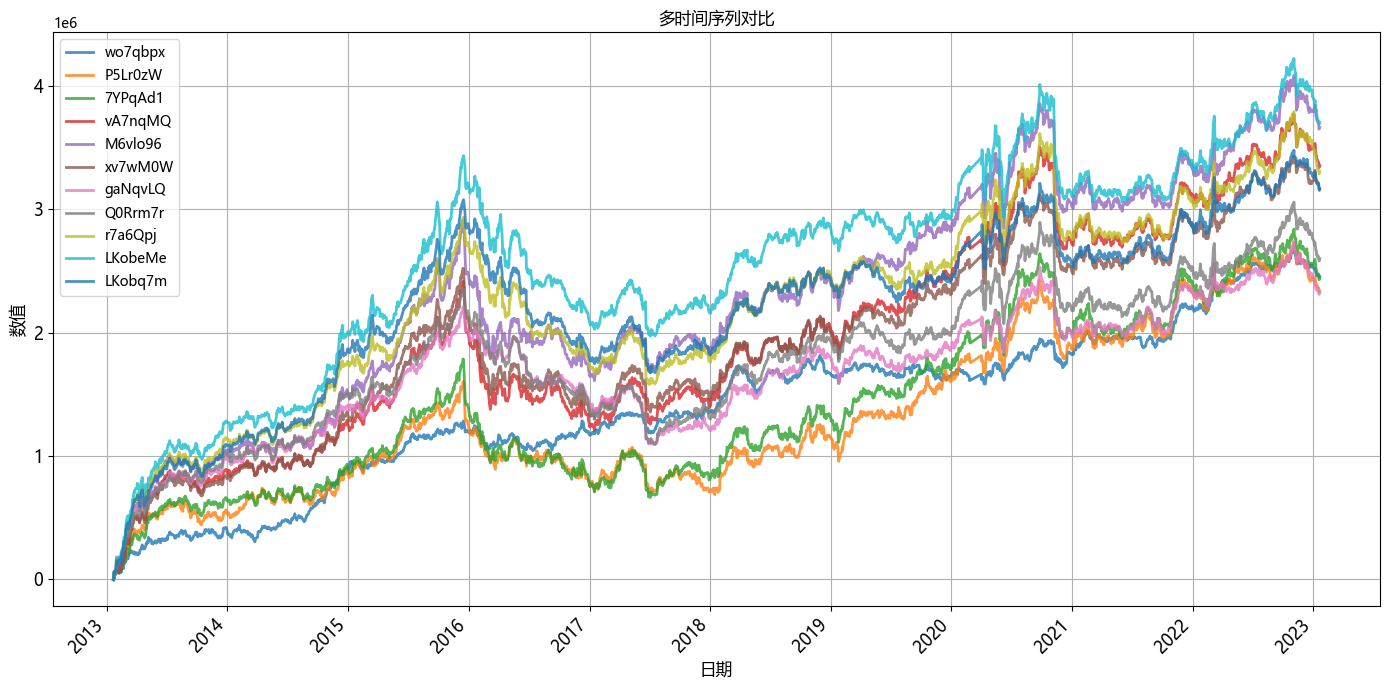

alpha_id  sharpe  fitness  turnover    margin
neutralization decay                                              
CROWDING       3      xv7wM0W    0.81     0.35    0.1642  0.000373
               13     LKobq7m    0.82     0.41    0.1090  0.000563
INDUSTRY       3      7YPqAd1    0.65     0.24    0.1682  0.000281
               13     Q0Rrm7r    0.73     0.33    0.1101  0.000458
MARKET         3      M6vlo96    0.81     0.38    0.1609  0.000441
               13     LKobeMe    0.79     0.42    0.1072  0.000670
SECTOR         3      vA7nqMQ    0.80     0.36    0.1635  0.000398
               13     r7a6Qpj    0.78     0.39    0.1081  0.000593
STATISTICAL    8      wo7qbpx    1.16     0.47    0.1472  0.000324
SUBINDUSTRY    3      P5Lr0zW    0.67     0.24    0.1731  0.000262
               13     gaNqvLQ    0.71     0.30    0.1125  0.000400

In [ ]:
# 设置matplotlib
plt.rcParams['font.sans-serif'] = ["Microsoft YaHei", "Arial Unicode MS"]  # 兼容win和mac的字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 绘制所有列（自动分配颜色和标签）
ax = df1.plot(
    figsize=(14, 7),
    linewidth=2,
    title='多时间序列对比',
    grid=True,
    alpha=0.8,
    fontsize=12
)
# 添加图例和标签
ax.set_xlabel('日期', fontsize=12)
ax.set_ylabel('数值', fontsize=12)
ax.legend(loc='upper left', frameon=True)
print(alpha_id_ori)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# 对dataframe进行回测
df_sorted = df_list.sort_values("neutralization")
df_multiindex = df_sorted.set_index(["neutralization", "decay"])
df_multiindex

![](https://pic1.imgdb.cn/item/68305fec58cb8da5c80a9f7c.jpg)